## 赛题说明
本题目提供的数据来自文件（windows 可执行程序）经过沙箱程序模拟运行后的API指令序列，全为windows二进制可执行程序，经过脱敏处理；

本题目提供的样本数据均来自于从互联网，其中恶意文件的类型有感染型病毒、木马程序、挖矿程序、DDOS木马、勒索病毒等，数据总计6亿条；

## 数据说明
**训练数据**（train.zip）：调用记录近9000万次，文件1万多个（以文件编号汇总），字段描述如下：

字段 | 类型 | 解释
-|-|-
file_id | bigint | 文件编号
label | bigint | 文件标签，0-正常/1-勒索病毒/2-挖矿程序/3-DDoS木马/4-蠕虫病毒/5-感染型病毒/6-后门程序/7-木马程序
api | string | 文件调用的API名称
tid | bigint | 调用API的线程编号
index | string | 线程中API调用的顺序编号

- 注1：一个文件调用的api数量有可能很多，对于一个tid中调用超过5000个api的文件，我们进行了截断，按照顺序保留了每个tid前5000个api的记录。
- 注2：不同线程tid之间没有顺序关系，同一个tid里的index由小到大代表调用的先后顺序关系。
- 注3：index是单个文件在沙箱执行时的全局顺序，由于沙箱执行时间有精度限制，所以会出现一个index上出现同线程或者不同线程都在执行多次api的情况，可以保证同tid内部的顺序，但不保证连续。
 
**测试数据**（test.zip）：调用记录近8000万次，文件1万多个。
> 说明：格式除了没有label字段，其他数据规格与训练数据一致。

## 评测指标
- 选手的结果文件包含9个字段：file_id(bigint)、和八个分类的预测概率prob0, prob1, prob2, prob3, prob4, prob5 ,prob6,prob7 (类型double，范围在[0,1]之间，精度保留小数点后5位，prob<=0.0我们会替换为1e-6，prob>=1.0我们会替换为1.0-1e-6)。选手必须保证每一行的|prob0+prob1+prob2+prob3+prob4+prob5+prob6+prob7-1.0|<1e-6，且将列名按如下顺序写入提交结果文件的第一行，作为表头：file_id,prob0,prob1,prob2,prob3,prob4,prob5,prob6,prob7。

- 分数采用logloss计算公式

## 字段分析

- file_id：表现每个程序文件，其中包含正常与各种异常类型，因此可以通过该字段做分组统计分析；
- label：训练标签，因此该问题是有监督学习；
- api：程序调用的api，由于是string类型，需要转为普通离散数据，且只支持连续值的算法此处不适用；
- tid：通过tid可以分组统计某个文件在某个线程中的调用时序，此处考虑HMM算法求转换概率；
- index：配合tid进行调用时序统计分析；

## 问题分析

简单讲模型需要预测一个未知文件为各个类别的概率，且概率和为1（接近1），训练数据有标签，因此是有监督学习，8个目标类别，因此是一个有监督多分类问题，目前还没有看过数据，但是通常存在极端的不平衡的情况，异常的文件数量远小于正常的文件，但这里跟普通异常检测不同的在于它需要精确的给出是哪一种异常，而不是简单的区分正常/异常，且需要算法输出的是各个类别的概率，而不是0/1；

## 环境

In [51]:
#coding:utf-8
## 导入模块以及环境设置
import os,sys,time,re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
#有中文出现的情况，需要u'内容'

%matplotlib inline

## 数据加载

由于数据量很大，训练csv文件2.9G，9000W条记录，1w个文件，因此采用pandas的分段加载方法，只加载部分数据做可视化分析；

In [2]:
train_path = '../../../ali_tianchi_dataset/恶意程序检测/security_train.csv'
test_path = '../../../ali_tianchi_dataset/恶意程序检测/security_test.csv'
submit_path = '../../../ali_tianchi_dataset/恶意程序检测/security_submit.csv'

In [3]:
def get_chunks(file_path=train_path, chunksize=900000):
    chunks = pd.read_csv(file_path, chunksize=chunksize)
    return chunks

In [69]:
train_data = pd.read_csv(train_path, nrows=9000*100)

In [70]:
train_data.head(5)

,file_id,label,api,tid,index
0,1,5,LdrLoadDll,2488,0
1,1,5,LdrGetProcedureAddress,2488,1
2,1,5,LdrGetProcedureAddress,2488,2
3,1,5,LdrGetProcedureAddress,2488,3
4,1,5,LdrGetProcedureAddress,2488,4


## 数据可视化分析

### 根据文件id分组

In [103]:
def groupby_fileid(data):
    file_data = pd.DataFrame(columns=['file_id','label','api_type_count',
                                      'tid_type_count','api_call_count'])
    for name,group in data.groupby('file_id'):
        file_data = file_data.append([{'file_id':name,'label':group.label.iloc[0],
                                       'api_type_count':len(group.api.unique()),
                                       'tid_type_count':len(group.tid.unique()),
                            'api_call_count':group.tid.count()}], ignore_index=True)
    return file_data

file_data = groupby_fileid(train_data)
file_data.head(10)

,file_id,label,api_type_count,tid_type_count,api_call_count
0,1,5,116,11,6786
1,2,2,30,4,816
2,3,0,42,1,463
3,4,0,51,4,1935


### 根据文件类型分组

In [104]:
def groupby_label(data):
    label_data = pd.DataFrame(columns=['label','api_type_count','tid_type_count','api_call_count'])
    for name,group in data.groupby('label'):
        label_data = label_data.append([{'label':name,'api_type_count':group.api_type_count.mean(),
                                        'tid_type_count':group.tid_type_count.mean(),
                                       'api_call_count':group.api_call_count.mean()}], ignore_index=True)
    return label_data

label_data = groupby_label(file_data)
print label_data

  label  api_type_count  tid_type_count  api_call_count
0     0            46.5             2.5          1199.0
1     2            30.0             4.0           816.0
2     5           116.0            11.0          6786.0


文件类型与调用的api类型总数的关系，可以看到差异并不明显；

<Container object of 7 artists>

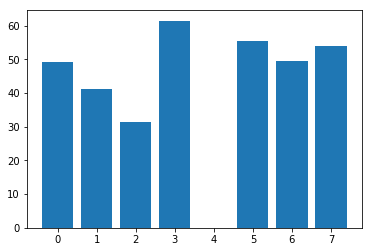

In [46]:
plt.bar(list(label_data.label), list(label_data.api_type_count_mean))

文件类型与使用线程个数的关系，可以看到各个类型之间有较大差异；

<Container object of 7 artists>

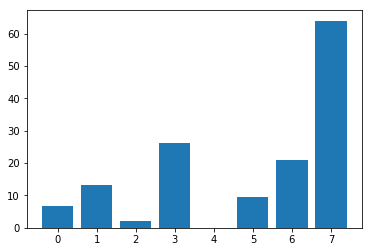

In [47]:
plt.bar(list(label_data.label), list(label_data.tid_type_count_mean))

文件类型与api调用总次数的关系，可以看到主要分为几个阶段，0,12,3,56,7；

<Container object of 7 artists>

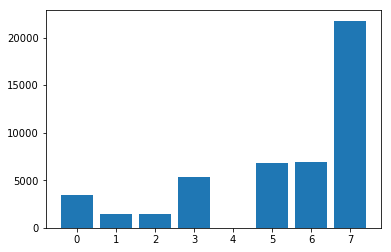

In [48]:
plt.bar(list(label_data.label), list(label_data.api_call_count_mean))

### 分析api前缀，通过前缀对api进行分组

输出所谓程序调用的api种类总数；

In [49]:
len(train_data.api.unique())

236

输出所有程序调用的api的前缀总数，api设计中通常前缀意味着同一簇；

In [65]:
api_list = train_data.api.unique()
api_prefix = []
for api in api_list:
    result = re.search(r'[A-Z]', api[1:])
    if result:
        prefix = api[:result.span()[0]+1]
    else:
        prefix = api
    api_prefix.append(prefix)
api_prefix = set(api_prefix)
print api_prefix
print len(api_prefix)

set(['Process32', 'getaddrinfo', 'Copy', 'Uuid', 'Crypt', 'Create', 'Send', 'ioctlsocket', 'Write', 'Start', 'Lookup', 'connect', 'getsockname', 'Internet', 'Encrypt', 'Net', 'Nt', 'Reg', 'select', 'Obtain', 'Draw', 'Thread32', 'Http', 'Get', 'Read', 'Enum', 'Unhook', 'send', 'time', 'Device', 'Delete', 'Cert', 'listen', 'Control', 'Search', 'I', 'Register', 'Remove', 'gethostbyname', 'S', 'Shell', 'W', 'Output', 'Module32', 'closesocket', 'socket', 'Load', 'setsockopt', 'Set', 'Co', 'Ole', 'bind', 'Is', 'Global', '__exception__', 'Ldr', 'Rtl', 'Sizeof', 'Open', 'Find'])
60


api分析需要针对api的用途做进一步分类处理，暂时搁置，TODO；

## 建模

1. 读取全部数据；
2. 划分数据集；
3. 对训练数据，根据文件id分组，根据labe分组；
4. 相应字段归一化；
5. 训练kNN模型；
6. 使用验证数据计算模型得分，k为1；

In [161]:
train_data = pd.read_csv(train_path, nrows=10000000)

In [162]:
file_data = groupby_fileid(train_data)
file_data.head(5)

,file_id,label,api_type_count,tid_type_count,api_call_count
0,1,5,116,11,6786
1,2,2,30,4,816
2,3,0,42,1,463
3,4,0,51,9,2046
4,5,0,65,6,10002


In [163]:
df = file_data[['api_type_count','tid_type_count','api_call_count']]
df.head(5)
file_data[['api_type_count','tid_type_count','api_call_count']] = (df - df.min()) / (df.max() - df.min())
file_data.head(5)

,file_id,label,api_type_count,tid_type_count,api_call_count
0,1,5,0.680473,0.00759301,0.0237334
1,2,2,0.171598,0.0022779,0.00285081
2,3,0,0.242604,0,0.00161604
3,4,0,0.295858,0.00607441,0.00715325
4,5,0,0.378698,0.00379651,0.0349827


In [164]:
from sklearn.cross_validation import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(file_data.drop('label', axis=1),file_data.label, test_size=0.25, random_state=0)
print len(x_train)
print len(x_valid)

1203
402


In [165]:
x_train['label'] = y_train
x_data = x_train
label_data = groupby_label(x_data)
x_train = label_data.drop('label', axis=1)
y_train = label_data.label
y_train = pd.DataFrame(y_train, columns=['label'])
x_train

,api_type_count,tid_type_count,api_call_count
0,0.253608,0.004231,0.010732
1,0.250296,0.032453,0.017498
2,0.226863,0.011006,0.021981
3,0.480769,0.035543,0.035358
4,0.431953,0.014680,0.015075
5,0.312245,0.014103,0.028575
6,0.314694,0.035371,0.036840
7,0.333909,0.024237,0.028524


x_valid['label'] = y_valid
x_data = x_valid
file_data = groupby_fileid(x_data)
x_valid = file_data.drop(['label','file_id'], axis=1)
y_valid = file_data.label
y_valid = pd.DataFrame(y_valid, columns=['label'])

In [166]:
x_valid = x_valid.drop('file_id', axis=1)

In [167]:
from sklearn.neighbors import KNeighborsClassifier as KNN
knn = KNN(1)
knn.fit(x_train,y_train.astype('int'))
scores=knn.score(x_valid, y_valid.astype('int'))
print scores

0.174129353234


/home/kael/Software/anaconda2/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [169]:
y_pred = knn.predict(x_valid)
print y_pred[:100]
print list(y_valid[:100])

[2 7 2 3 4 2 2 2 0 3 2 2 5 5 0 4 5 0 3 2 5 3 2 2 7 2 3 2 2 3 4 3 0 2 2 2 5
 0 2 6 3 2 6 5 2 7 7 2 2 3 5 2 2 2 2 2 2 2 0 4 4 7 2 7 2 2 5 7 0 2 7 4 0 2
 3 0 2 2 2 3 2 2 2 2 3 0 2 5 2 0 3 2 0 3 2 4 2 5 5 2]
[5, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 1, 0, 0, 0, 5, 0, 5, 0, 7, 5, 6, 0, 0, 0, 3, 5, 0, 7, 0, 7, 0, 6, 5, 0, 5, 0, 2, 1, 5, 0, 6, 2, 0, 0, 5, 2, 2, 3, 0, 2, 2, 2, 3, 5, 5, 5, 0, 5, 0, 5, 0, 0, 5, 2, 5, 0, 5, 0, 0, 5, 5, 6, 7, 0, 0, 2, 5, 3, 0, 0, 5, 5, 7, 1, 5, 5, 0, 7, 0, 5, 0, 3, 3, 5, 5, 0, 0, 5]


可以看到准确率很低，因此根据file_id、label分组失败，主要原因是简单的进行mean生成新特征丢失了很多原始信息，应该在分组上下更多力气，比如对于label为0的情况下，根据api的调用情况进行区分，将label为0的数组分为N中情况统计并生成新特征，然后通过对K取值来进行预测；

[HMM](https://hmmlearn.readthedocs.io/en/latest/tutorial.html#building-hmm-and-generating-samples)